In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import plot_compare
from utils.data import get_events, get_sections, load_df, export_dataframe_to_latex

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/"

# Data

Train size ≃ 65.92%
Test  size ≃ 34.08%


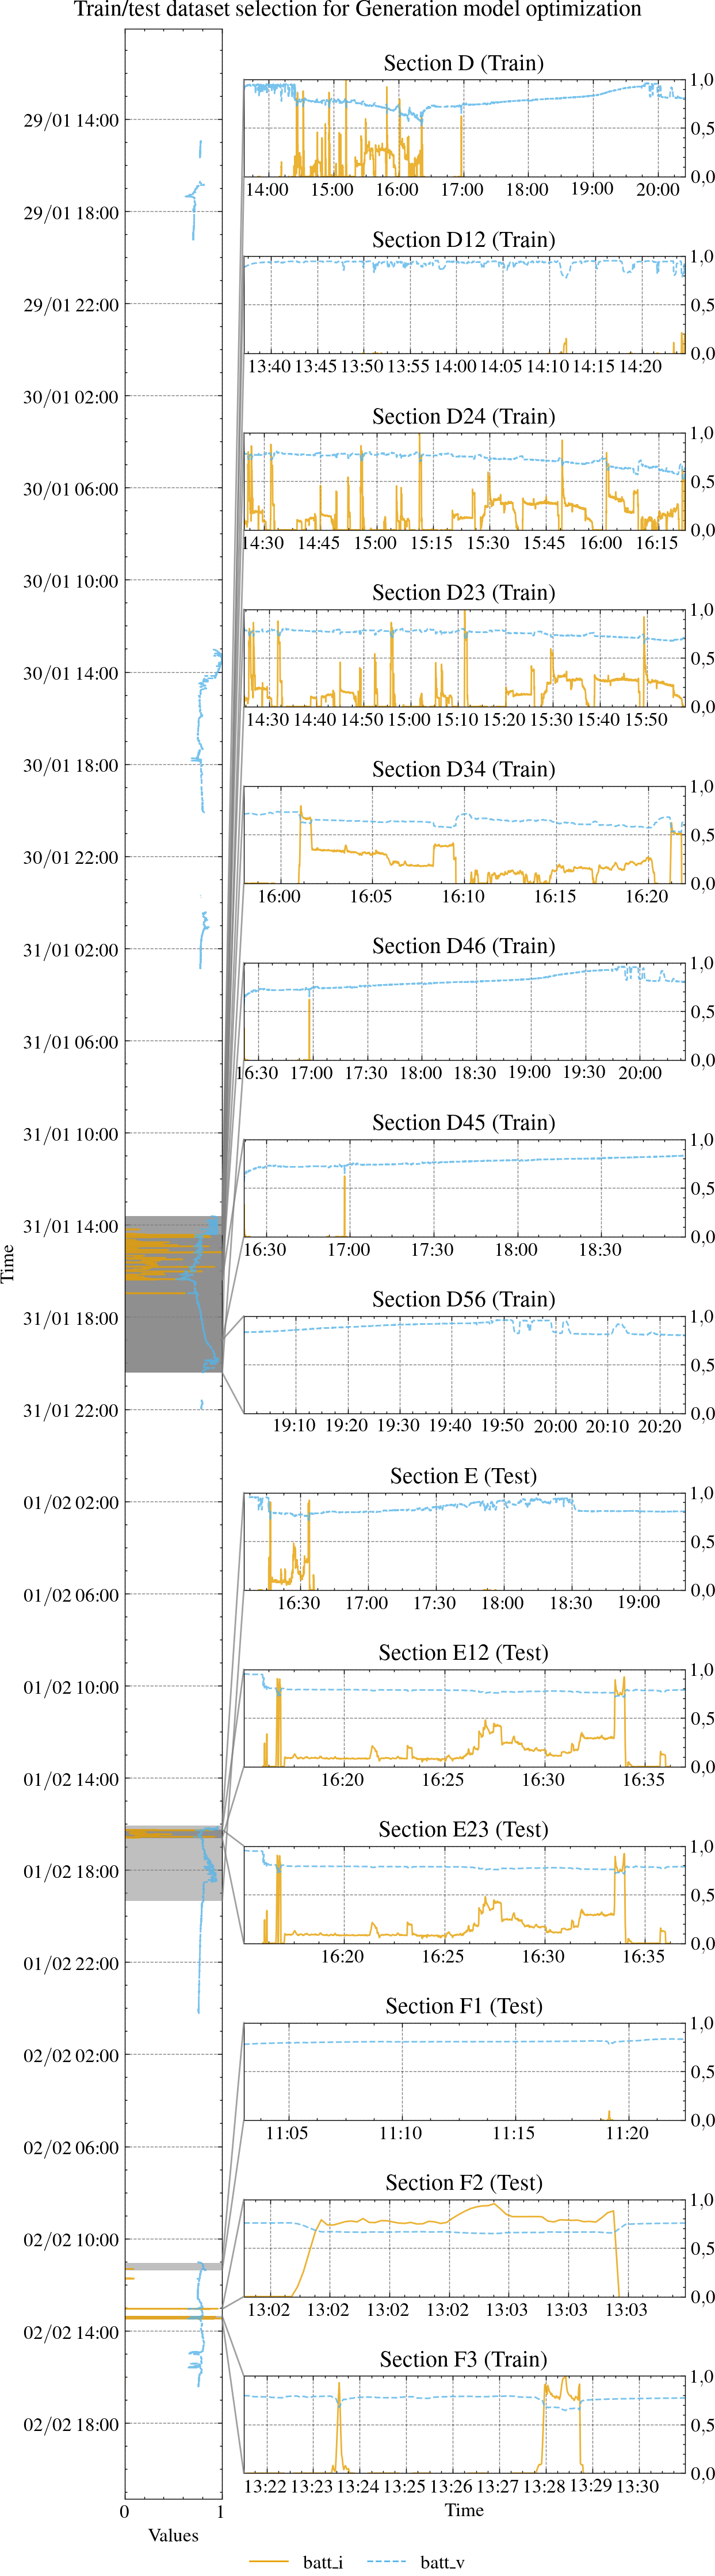

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    "Battery Pack Voltage": "batt_v",
    "Battery Current": "batt_i",
    "ESC Duty Cycle": "pilot_d",
    "Motor Angular Speed": "motor_w",
    "ESC Input Current": "esc_i_in",
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    "MPPTs Output Current": "mppts_i_out",
    "PVs G": "pv_g",
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp(
    "2020-01-31 13:37:04"
)  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp("2020-01-31 14:24:40")  # start of the race
D3 = pd.Timestamp("2020-01-31 15:58:00")  # battery enters in deep-discharge
D4 = pd.Timestamp("2020-01-31 16:22:00")  # race finishes, post-race charge starts
D5 = pd.Timestamp("2020-01-31 19:00:00")  # overcharge starts
D6 = pd.Timestamp("2020-01-31 20:24:55")  # end of the day
sections.loc["Section D"] = [D1, D6]  # Full race event
sections.loc["Section D12"] = [D1, D2]  # Full pre-race charge
sections.loc["Section D24"] = [D2, D4]  # Full race discharge
sections.loc["Section D23"] = [D2, D3]  # Race normal discharge range
sections.loc["Section D34"] = [D3, D4]  # Race deep-discharge range
sections.loc["Section D46"] = [D4, D6]  # Full post-race charge
sections.loc["Section D45"] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc["Section D56"] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc["Section E"] = [
    pd.Timestamp("2020-02-01 16:05:00"),
    pd.Timestamp("2020-02-01 19:20:00"),
]  # A quick 15min discharge followed by an overcharge
sections.loc["Section E12"] = [
    pd.Timestamp("2020-02-01 16:15:00"),
    pd.Timestamp("2020-02-01 16:37:00"),
]  # A ~15min discharge
sections.loc["Section E23"] = [
    pd.Timestamp("2020-02-01 16:15:00"),
    pd.Timestamp("2020-02-01 16:37:00"),
]  # Another over-charging section
sections.loc["Section F1"] = [
    pd.Timestamp("2020-02-02 11:03:00"),
    pd.Timestamp("2020-02-02 11:22:30"),
]  # A quick charge section
sections.loc["Section F2"] = [
    pd.Timestamp("2020-02-02 13:02:15"),
    pd.Timestamp("2020-02-02 13:03:30"),
]  # 2min high-current pulse
sections.loc["Section F3"] = [
    pd.Timestamp("2020-02-02 13:21:30"),
    pd.Timestamp("2020-02-02 13:31:00"),
]  # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[
    [
        "Section D",
        "Section D12",
        "Section D24",
        "Section D23",
        "Section D34",
        "Section D46",
        "Section D45",
        "Section D56",
        "Section E",
        "Section E12",
        "Section E23",
        "Section F1",
        "Section F2",
        "Section F3",
    ]
]

train_sections_names = [
    "Section D",
    "Section D12",
    "Section D24",
    "Section D23",
    "Section D34",
    "Section D46",
    "Section D45",
    "Section D56",
    "Section F3",
]

train_test_sections = sections.reset_index().to_dict(orient="records")
train_sections = (
    sections.loc[sections.index.intersection(train_sections_names)]
    .reset_index()
    .to_dict(orient="records")
)
test_sections = (
    sections.loc[sections.index.difference(train_sections_names)]
    .reset_index()
    .to_dict(orient="records")
)
all_sections = sections.reset_index().to_dict(orient="records")

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec["start"]) & (df.index <= sec["end"])
    if sec["name"] in train_sections_names:
        sec["name"] = sec["name"] + " (Train)"
        train_mask |= mask
    else:
        sec["name"] = sec["name"] + " (Test)"
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f"Train size ≃ {100*train_size/total_size:.2f}%")
print(f"Test  size ≃ {100*test_size/total_size:.2f}%")


def boat_speed_from_motor_v(motor_v, a=0.54340307 / 3.6):
    return a * motor_v  # [m/s]


df["hull_u"] = boat_speed_from_motor_v(df["batt_v"] * df["pilot_d"])

fig_save_and_show(
    filename=None,  # f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
    show_title=f"Train/test dataset selection for Generation model optimization",
    save_title=f"Dataset da embarcação durante o DSB de 2019",
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=["batt_i", "batt_v"],
        normalize=True,
    ),
)

# Solar Boat System model

In [4]:
import numpy as np
import control as ct
import math


def eval_poly(coeffs, x):
    coeffs = list(coeffs)
    if len(coeffs) == 0:
        return 0.0
    if len(coeffs) == 1:
        return coeffs[0]

    result = 0.0
    for c in reversed(coeffs[1:]):
        result = result * x + c
    return result * x + coeffs[0]


class SolarBoat:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        if "batt_z" not in X0 or "batt_v" not in X0:
            raise ValueError(
                "X0 must contain 'batt_z' and 'batt_v' for SolarBoat.initial_state."
            )

        # Required initial conditions
        batt_z_0 = X0["batt_z"]
        batt_v_0 = X0["batt_v"]

        # Optional: initial hull speed
        hull_u_0 = X0.get("hull_u", 0.0)

        # Inputs
        # pv_g_0 = U0[0] if len(U0) > 0 else 0.0
        pilot_d_0 = U0[1] if len(U0) > 1 else 0.0

        # --- Battery RC states ---------------------------------------------
        # Params
        batt_R_0 = params["batt_R_0"]
        batt_k_V_OC_coeffs = params["batt_k_V_OC_coeffs"]
        batt_N_S = params["batt_N_S"]

        # [ASSUMPTION]: At t=0, battery current is 0 A when computing RC initial voltages.
        batt_i_0 = 0.0

        # OCV at initial SoC
        batt_ocv_0 = eval_poly(batt_k_V_OC_coeffs, batt_z_0)

        # v_C1_0 = v_C2_0 = v_C_0 so that terminal voltage matches batt_v_0:
        # batt_v_0 / batt_N_S = batt_ocv_0 - 2*v_C_0 - batt_R_0 * batt_i_0
        v_C_0 = (batt_ocv_0 - batt_R_0 * batt_i_0 - batt_v_0 / batt_N_S) / 2.0

        batt_v_C_1_0 = v_C_0
        batt_v_C_2_0 = v_C_0

        # --- Propulsion states ---------------------------------------------
        # [ASSUMPTION]: Motor starts from rest with zero current, and ESC duty equals pilot input.
        motor_i_0 = 0.0
        motor_w_0 = 0.0
        esc_d_0 = pilot_d_0

        return np.array(
            [
                batt_v_C_1_0,
                batt_v_C_2_0,
                batt_z_0,
                motor_i_0,
                motor_w_0,
                esc_d_0,
                hull_u_0,
            ]
        )

    @classmethod
    def _common(cls, t, x, u, params: dict):
        # Parameters:
        esc_F_s = params["esc_F_s"]
        esc_V_ds_ov = params["esc_V_ds_ov"]
        esc_R_ds_on = params["esc_R_ds_on"]
        esc_E_on = params["esc_E_on"]
        esc_E_off = params["esc_E_off"]
        esc_V_F = params["esc_V_F"]
        esc_r_D = params["esc_r_D"]
        esc_Q_rr = params["esc_Q_rr"]
        batt_R_0 = params["batt_R_0"]
        batt_N_S = params["batt_N_S"]
        batt_k_V_OC_coeffs = params["batt_k_V_OC_coeffs"]
        mppts_n = params["mppts_n"]
        mppt_eta = params["mppt_eta"]
        pv_eta = params["pv_eta"]
        pv_S = params["pv_S"]
        oth_p_in = params["oth_p_in"]

        # Inputs:
        pv_g = u[0]
        # pilot_d = u[1]

        # States:
        batt_v_C_1 = x[0]
        batt_v_C_2 = x[1]
        batt_z = x[2]
        motor_i = x[3]
        # motor_w = x[4]
        esc_d = x[5]
        # hull_u = x[6]

        # Outputs:
        eps = 1e-6
        batt_v_oc = max(eval_poly(batt_k_V_OC_coeffs, batt_z), eps)
        batt_v = (
            (1 / 2)
            * math.sqrt(batt_N_S)
            * math.sqrt(
                batt_N_S
                * (
                    -batt_R_0 * esc_F_s * esc_Q_rr * esc_V_ds_ov
                    - batt_R_0 * esc_F_s * esc_Q_rr
                    - batt_R_0 * esc_d * motor_i
                    - batt_v_C_1
                    - batt_v_C_2
                    + batt_v_oc
                )
                ** 2
                - 4 * batt_R_0 * esc_E_off * esc_F_s * esc_V_ds_ov
                - 4 * batt_R_0 * esc_E_off * esc_F_s
                - 4 * batt_R_0 * esc_E_on * esc_F_s * esc_V_ds_ov
                - 4 * batt_R_0 * esc_E_on * esc_F_s
                - 4 * batt_R_0 * esc_R_ds_on * esc_d * motor_i**2
                + 4 * batt_R_0 * esc_V_F * esc_d * motor_i
                - 4 * batt_R_0 * esc_V_F * motor_i
                + 4 * batt_R_0 * esc_r_D * esc_d * motor_i**2
                - 4 * batt_R_0 * esc_r_D * motor_i**2
                + 4 * batt_R_0 * mppts_n * pv_S * mppt_eta * pv_eta * pv_g
                - 4 * batt_R_0 * oth_p_in
            )
            - 1 / 2 * batt_N_S * batt_R_0 * esc_F_s * esc_Q_rr * esc_V_ds_ov
            - 1 / 2 * batt_N_S * batt_R_0 * esc_F_s * esc_Q_rr
            - 1 / 2 * batt_N_S * batt_R_0 * esc_d * motor_i
            - 1 / 2 * batt_N_S * batt_v_C_1
            - 1 / 2 * batt_N_S * batt_v_C_2
            + (1 / 2) * batt_N_S * batt_v_oc
        )
        mppts_i_out = mppts_n * pv_S * mppt_eta * pv_eta * pv_g / batt_v
        esc_i_in = (
            esc_F_s * esc_Q_rr * (esc_V_ds_ov + 1) * batt_v
            + esc_F_s * (esc_E_off + esc_E_on) * (esc_V_ds_ov + 1)
            + esc_R_ds_on * esc_d * motor_i**2
            - esc_V_F * (esc_d - 1) * motor_i
            - esc_r_D * (esc_d - 1) * motor_i**2
            + esc_d * motor_i * batt_v
        ) / batt_v

        return [batt_v, mppts_i_out, esc_i_in]

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Parameters:
        rho_water = params["rho_water"]
        prop_D = params["prop_D"]
        prop_I_r = params["prop_I_r"]
        prop_k_T_coeffs = params["prop_k_T_coeffs"]
        prop_k_Q_coeffs = params["prop_k_Q_coeffs"]
        rho_air = params["rho_air"]
        hull_S_water = params["hull_S_water"]
        hull_S_air = params["hull_S_air"]
        hull_C_T = params["hull_C_T"]
        hull_M = params["hull_M"]
        hull_M_a = params["hull_M_a"]
        prop_eta_R = params["prop_eta_R"]
        hull_W = params["hull_W"]
        hull_T_ded = params["hull_T_ded"]
        trans_k = params["trans_k"]
        trans_I_r_out = params["trans_I_r_out"]
        trans_I_r_in = params["trans_I_r_in"]
        trans_eta = params["trans_eta"]
        motor_R_A = params["motor_R_A"]
        motor_L_A = params["motor_L_A"]
        motor_K_Q = params["motor_K_Q"]
        motor_K_V = params["motor_K_V"]
        motor_I_r = params["motor_I_r"]
        motor_B = params["motor_B"]
        esc_tau_rise = params["esc_tau_rise"]
        esc_tau_fall = params["esc_tau_fall"]
        batt_R_1 = params["batt_R_1"]
        batt_C_1 = params["batt_C_1"]
        batt_R_2 = params["batt_R_2"]
        batt_C_2 = params["batt_C_2"]
        batt_Q = params["batt_Q"]
        batt_eta = params["batt_eta"]
        oth_p_in = params["oth_p_in"]

        # Inputs:
        # pv_g = u[0]
        pilot_d = u[1]

        # States:
        batt_v_C_1 = x[0]
        batt_v_C_2 = x[1]
        # batt_z = x[2]
        motor_i = x[3]
        motor_w = x[4]
        esc_d = x[5]
        hull_u = x[6]

        batt_v, mppts_i_out, esc_i_in = cls._common(t, x, u, params)

        # Auxiliars:
        eps = 1e-6
        oth_i_in = oth_p_in / batt_v
        batt_i = esc_i_in - mppts_i_out + oth_i_in
        motor_I_r_load = trans_I_r_in + trans_k**2 * (prop_I_r + trans_I_r_out)
        motor_v = esc_d * batt_v
        prop_n = (1 / 2) * trans_k * motor_w / math.pi
        prop_j = max(0, min((1 - hull_W) * hull_u / (prop_D * (prop_n + eps)), 1.5))
        prop_k_t_ow = max(0, eval_poly(prop_k_T_coeffs, prop_j))
        prop_k_q_ow = max(0, eval_poly(prop_k_Q_coeffs, prop_j))
        prop_t = prop_D**4 * rho_water * prop_k_t_ow * prop_n**2
        prop_q = prop_D**5 * rho_water * prop_k_q_ow * prop_n**2 / prop_eta_R
        hull_r_t = (
            (1 / 2)
            * hull_C_T
            * (hull_S_air * rho_air + hull_S_water * rho_water)
            * hull_u**2
        )
        hull_r = -hull_r_t / (hull_T_ded - 1)
        motor_q_load = trans_k * prop_q / trans_eta

        d_batt_v_C_1 = (batt_R_1 * batt_i - batt_v_C_1) / (batt_C_1 * batt_R_1)
        d_batt_v_C_2 = (batt_R_2 * batt_i - batt_v_C_2) / (batt_C_2 * batt_R_2)
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_motor_i = (-motor_K_V * motor_w - motor_R_A * motor_i + motor_v) / motor_L_A
        d_motor_w = (-motor_B * motor_w + motor_K_Q * motor_i - motor_q_load) / (
            motor_I_r + motor_I_r_load
        )
        d_esc_d = (
            ((-esc_d + pilot_d) / esc_tau_rise)
            if (esc_d < pilot_d)
            else ((-esc_d + pilot_d) / esc_tau_fall)
        )
        d_hull_u = (-hull_r + prop_t) / (hull_M + hull_M_a)

        return [
            d_batt_v_C_1,
            d_batt_v_C_2,
            d_batt_z,
            d_motor_i,
            d_motor_w,
            d_esc_d,
            d_hull_u,
        ]

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # States:
        # batt_v_C_1 = x[0]
        # batt_v_C_2 = x[1]
        # batt_z = x[2]
        # motor_i = x[3]
        motor_w = x[4]
        esc_d = x[5]
        hull_u = x[6]

        # Outputs:
        batt_v, mppts_i_out, esc_i_in = cls._common(t, x, u, params)

        return [batt_v, mppts_i_out, motor_w, esc_i_in, esc_d, hull_u]

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name="solarboat",
            inputs=["pv_g", "pilot_d"],
            states=[
                "batt_v_C_1",
                "batt_v_C_2",
                "batt_z",
                "motor_i",
                "motor_w",
                "esc_d",
                "hull_u",
            ],
            outputs=["batt_v", "mppts_i_out", "motor_w", "esc_i_in", "esc_d", "hull_u"],
            params=params,
        )


SolarBoat.build({})

<NonlinearIOSystem solarboat: ['pv_g', 'pilot_d'] -> ['batt_v', 'mppts_i_out', 'motor_w', 'esc_i_in', 'esc_d', 'hull_u']>

In [5]:
from utils.optimization import load_model_params_from_json


generation_params = load_model_params_from_json('../../../models/2020/generation/generation_params.json')
battery_params = load_model_params_from_json('../../../models/2020/battery/PNGV_2rc_params.json')
propulsion_params = load_model_params_from_json('../../../models/2020/propulsion/propulsion_params.json')

In [7]:
from utils.optimization import save_model_params_to_json


others_params = {
    "oth_p_in": 1.5 * 18,
}

solar_boat_params = (
    generation_params | battery_params | propulsion_params | others_params
)
save_model_params_to_json('solar_boat_params.json', solar_boat_params)

solar_boat_params

{'mppt_eta': 0.9169847543904102,
 'mppts_n': 4,
 'pv_S': 1.6367999999999998,
 'pv_eta': 0.15553707966836625,
 'batt_C_1': 178.5586606298482,
 'batt_C_2': 144235.60217487614,
 'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_R_0': 0.004348118891262343,
 'batt_R_1': 0.0051659150313201774,
 'batt_R_2': 0.07033472607300116,
 'batt_eta': 1,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_V_F': 3.338359854985,
 'esc_V_ds_ov': 2.0,
 'esc_r_D': 0.004027165799996619,
 'esc_tau_fall': 0.05382311411057277,
 'esc_tau_rise': 0.45185746234392316,
 'hull_C_T': 0.005448399998501737,
 'hull_M': 293.7,
 'hull_M_a': 0.15195016919075136,
 'hull_S_air': 4.188174709710495,
 'hull_S_water': 4.050226176680205,
 'hull_T_ded': 0.4184892215005117,
 'hull_W': 0.0007050254981052087,
 'motor_B': 0.0012793008044770459,
 'motor_I_r': 0.011828773027862982,
 'motor_

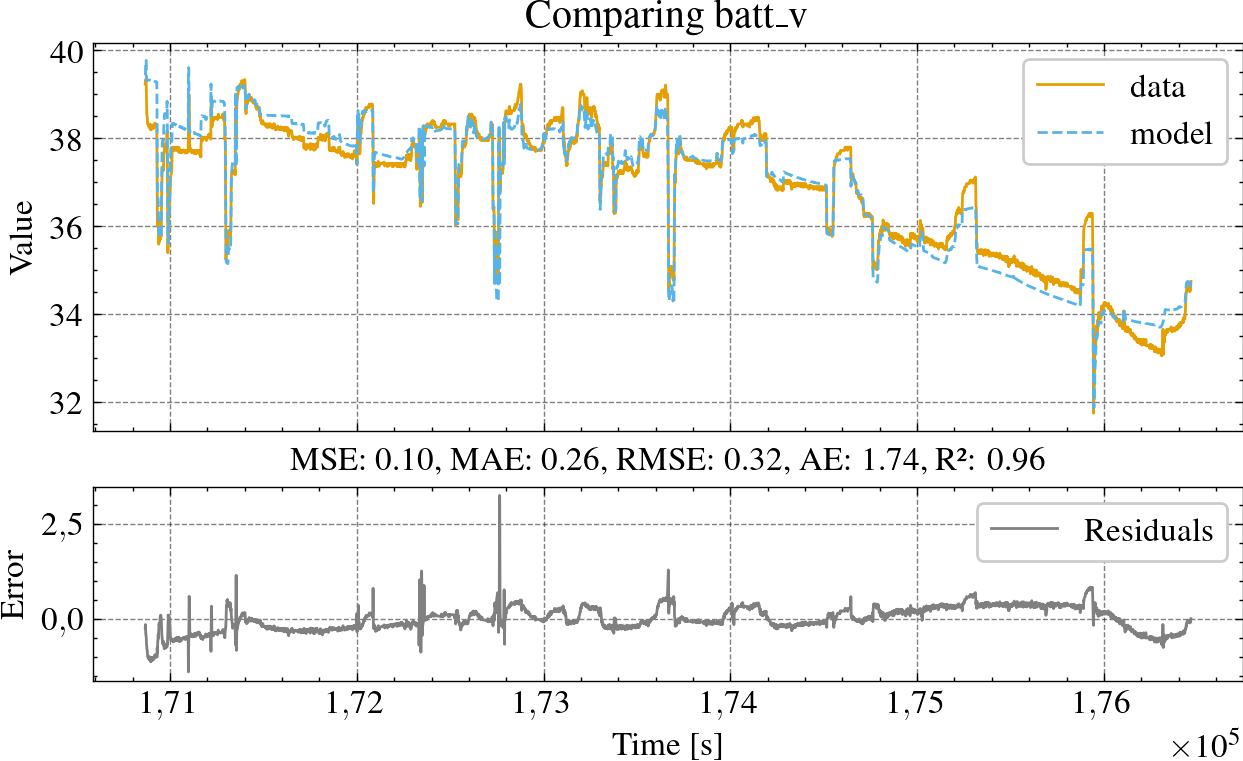

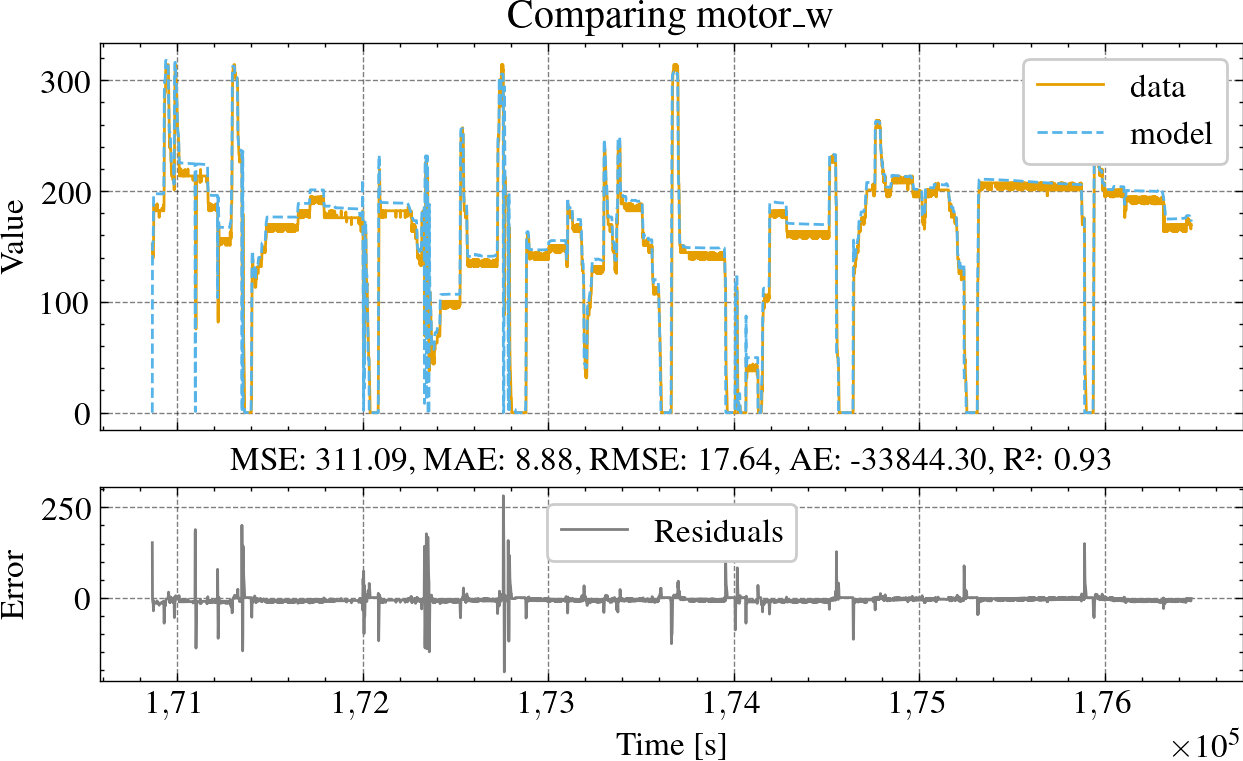

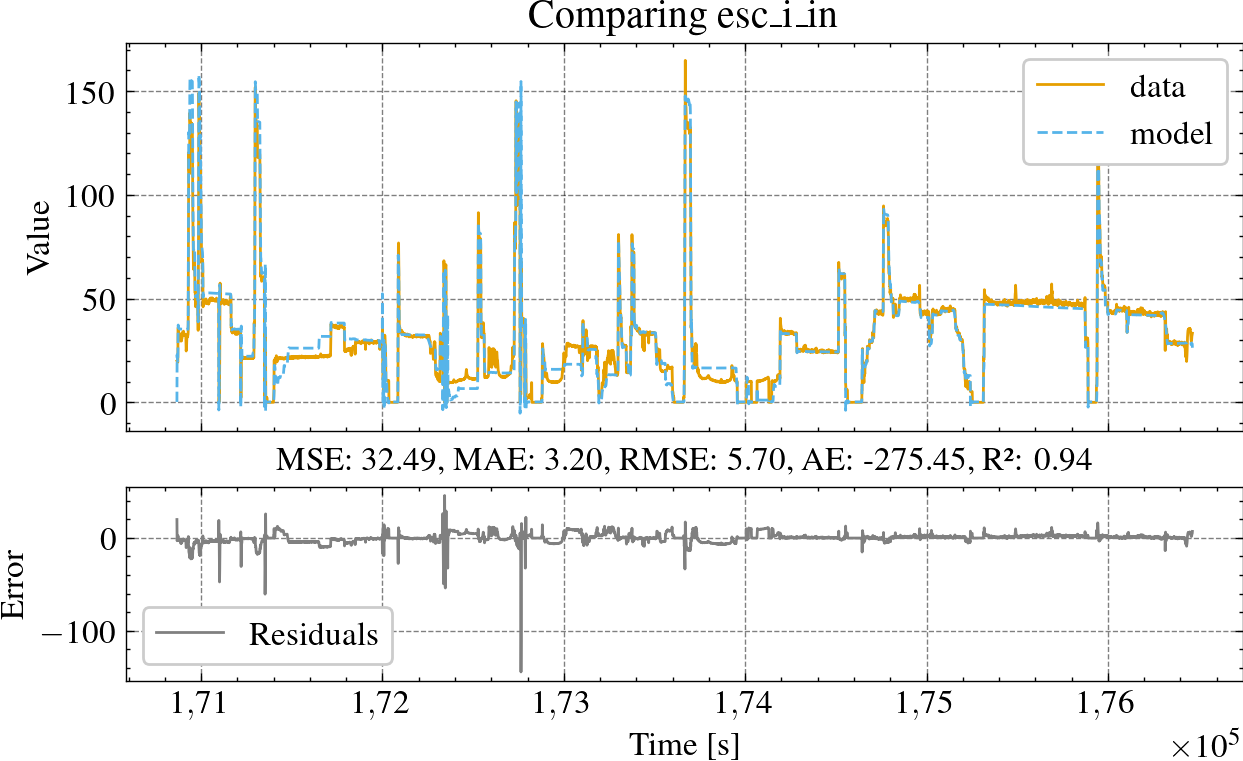

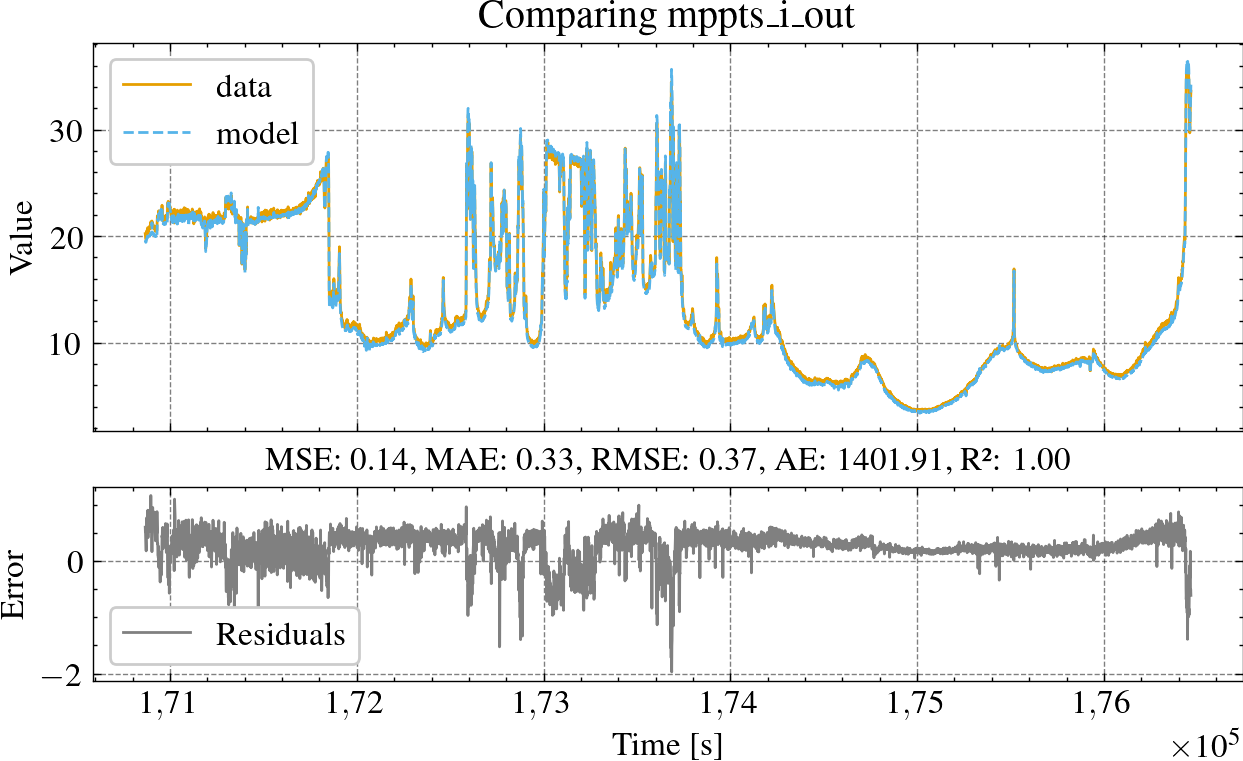

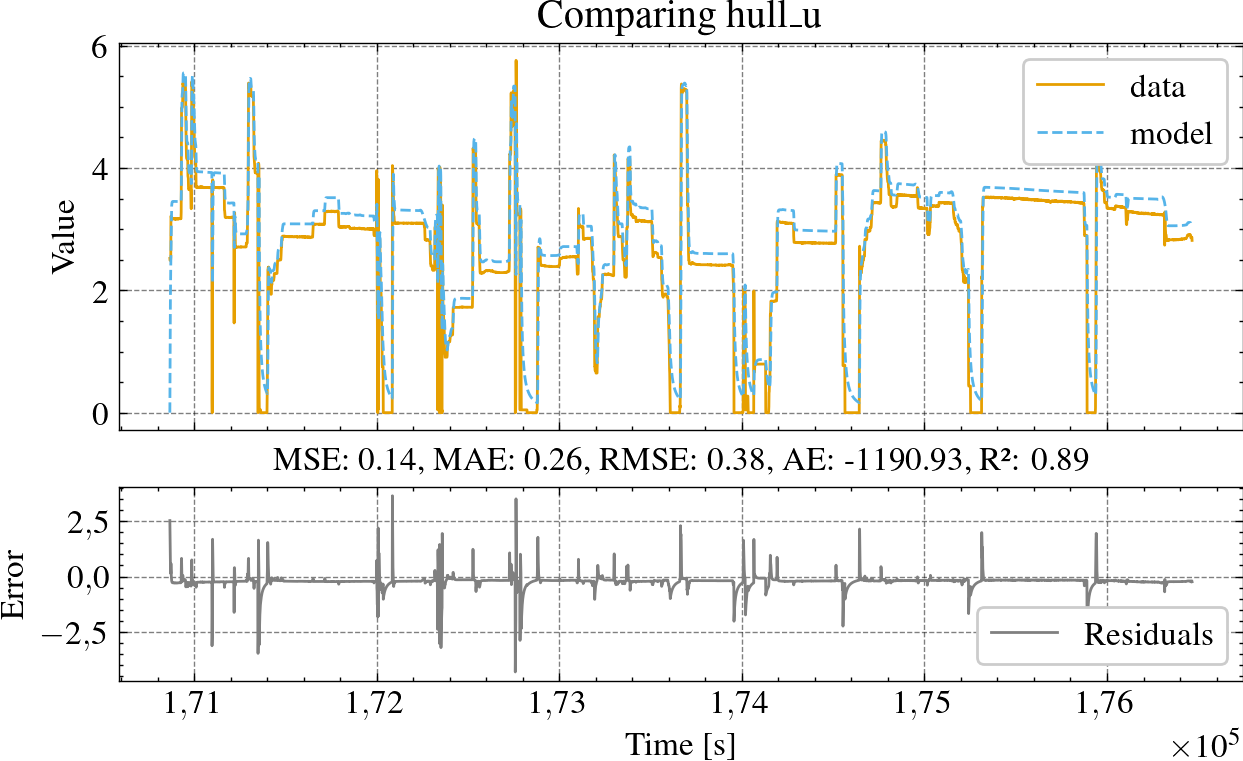

In [7]:
def simulate_solat_boat(df, model_params):
    model = SolarBoat
    model_params = solar_boat_params.copy()

    # Model
    solar_boat = model.build(model_params)
    input_cols = solar_boat.input_labels

    # Time array
    T = np.ascontiguousarray(df["t"].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df[input_cols].to_numpy().T)

    # Initial state
    X0 = model.initial_state(
        X0={
            "batt_z": 1.2,
            "batt_v": float(df["batt_v"].iloc[0]),
        },
        U0=U[:, 0],
        params=model_params,
    )

    # Simulation
    res = ct.input_output_response(
        solar_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau"
    )
    df_out = res.to_pandas()
    df_out['t'] = df_out['time'] - df_out['time'].iloc[0]

    return df_out.set_index("time")


section_name = "Section D23"
section = next(s for s in all_sections if s["name"] == section_name)
df_section = df.loc[(df.index >= section["start"]) & (df.index <= section["end"])]

df_pred = simulate_solat_boat(df_section, solar_boat_params)

solar_boat_signals = SolarBoat.build(solar_boat_params)
data_cols = [c for c in list(df.columns) if c in solar_boat_signals.output_labels]
for column in data_cols:
    plot_compare(df_section, df_pred, column)

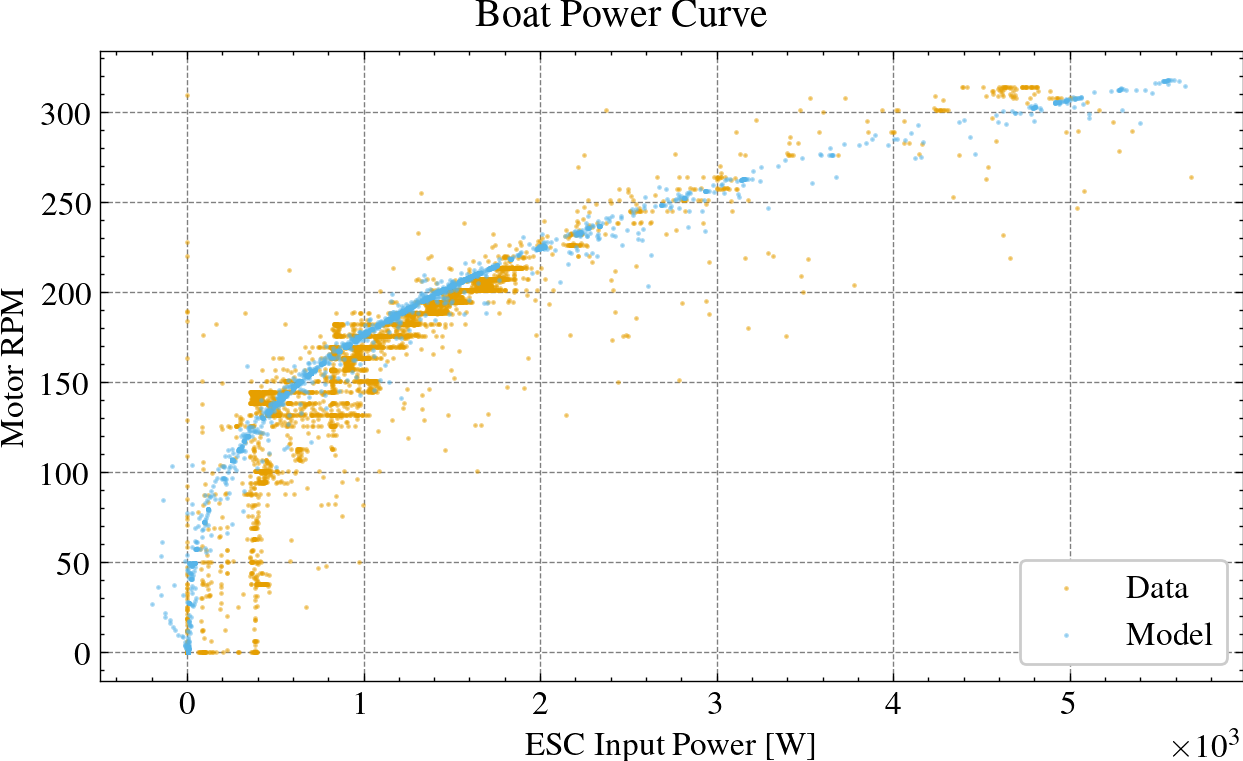

In [8]:
plt.figure()
plt.scatter(
    df_section["batt_v"].to_numpy() * df_section["esc_i_in"].to_numpy(),
    df_section["motor_w"],
    s=0.5,
    alpha=0.5,
    label="Data",
)
plt.scatter(
    df_pred["batt_v"].to_numpy() * df_pred["esc_i_in"].to_numpy(),
    df_pred["motor_w"],
    s=0.5,
    alpha=0.5,
    label="Model",
)
plt.suptitle("Boat Power Curve")
plt.ylabel("Motor RPM")
plt.xlabel("ESC Input Power [W]")
plt.legend()
plt.show()

# SolarBoat Full Model

In [9]:
import numpy as np
import control as ct
import math


def eval_poly(coeffs, x):
    coeffs = list(coeffs)
    if len(coeffs) == 0:
        return 0.0
    if len(coeffs) == 1:
        return coeffs[0]

    result = 0.0
    for c in reversed(coeffs[1:]):
        result = result * x + c
    return result * x + coeffs[0]


class SolarBoatInternalSignalModel:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        if "batt_z" not in X0 or "batt_v" not in X0:
            raise ValueError(
                "X0 must contain 'batt_z' and 'batt_v' for SolarBoat.initial_state."
            )

        # Required initial conditions
        batt_z_0 = X0["batt_z"]
        batt_v_0 = X0["batt_v"]

        # Optional: initial hull speed
        hull_u_0 = X0.get("hull_u", 0.0)

        # Inputs
        # pv_g_0 = U0[0] if len(U0) > 0 else 0.0
        pilot_d_0 = U0[1] if len(U0) > 1 else 0.0

        # --- Battery RC states ---------------------------------------------
        # Params
        batt_R_0 = params["batt_R_0"]
        batt_k_V_OC_coeffs = params["batt_k_V_OC_coeffs"]
        batt_N_S = params["batt_N_S"]

        # [ASSUMPTION]: At t=0, battery current is 0 A when computing RC initial voltages.
        batt_i_0 = 0.0

        # OCV at initial SoC
        batt_ocv_0 = eval_poly(batt_k_V_OC_coeffs, batt_z_0)

        # v_C1_0 = v_C2_0 = v_C_0 so that terminal voltage matches batt_v_0:
        # batt_v_0 / batt_N_S = batt_ocv_0 - 2*v_C_0 - batt_R_0 * batt_i_0
        v_C_0 = (batt_ocv_0 - batt_R_0 * batt_i_0 - batt_v_0 / batt_N_S) / 2.0

        batt_v_C_1_0 = v_C_0
        batt_v_C_2_0 = v_C_0

        # --- Propulsion states ---------------------------------------------
        # [ASSUMPTION]: Motor starts from rest with zero current, and ESC duty equals pilot input.
        motor_i_0 = 0.0
        esc_d_0 = pilot_d_0

        return np.array(
            [
                batt_v_C_1_0,
                batt_v_C_2_0,
                batt_z_0,
                motor_i_0,
                esc_d_0,
                hull_u_0,
            ]
        )

    @classmethod
    def _aux(cls, t, x, u, params: dict):
        # Params
        hull_C_T = params["hull_C_T"]
        hull_S_air = params["hull_S_air"]
        hull_S_water = params["hull_S_water"]
        hull_T_ded = params["hull_T_ded"]
        hull_W = params["hull_W"]
        oth_p_in = params["oth_p_in"]
        prop_D = params["prop_D"]
        prop_eta_R = params["prop_eta_R"]
        prop_I_r = params["prop_I_r"]
        prop_k_Q_coeffs = params["prop_k_Q_coeffs"]
        prop_k_T_coeffs = params["prop_k_T_coeffs"]
        rho_air = params["rho_air"]
        rho_water = params["rho_water"]
        trans_eta = params["trans_eta"]
        trans_I_r_in = params["trans_I_r_in"]
        trans_I_r_out = params["trans_I_r_out"]
        trans_k = params["trans_k"]
        batt_k_V_OC_coeffs = params["batt_k_V_OC_coeffs"]

        # Inputs
        # pv_g = u[0]
        # pilot_d = u[1]
        batt_v = u[2]
        mppts_i_out = u[3]
        motor_w = u[4]
        esc_i_in = u[5]

        # States
        # batt_v_C_1 = x[0]
        # batt_v_C_2 = x[1]
        batt_z = x[2]
        # motor_i = x[3]
        esc_d = x[4]
        hull_u = x[5]

        eps = 1e-6
        batt_v_oc = max(eval_poly(batt_k_V_OC_coeffs, batt_z), eps)
        oth_i_in = oth_p_in / batt_v
        batt_i = esc_i_in - mppts_i_out + oth_i_in
        motor_I_r_load = trans_I_r_in + trans_k**2 * (prop_I_r + trans_I_r_out)
        motor_v = esc_d * batt_v
        prop_n = (1 / 2) * trans_k * motor_w / math.pi
        prop_j = max(0, min((1 - hull_W) * hull_u / (prop_D * (prop_n + eps)), 1.5))
        prop_k_t_ow = max(0, eval_poly(prop_k_T_coeffs, prop_j))
        prop_k_q_ow = max(0, eval_poly(prop_k_Q_coeffs, prop_j))
        prop_t = prop_D**4 * rho_water * prop_k_t_ow * prop_n**2
        prop_q = prop_D**5 * rho_water * prop_k_q_ow * prop_n**2 / prop_eta_R
        hull_r_t = (
            (1 / 2)
            * hull_C_T
            * (hull_S_air * rho_air + hull_S_water * rho_water)
            * hull_u**2
        )
        hull_r = -hull_r_t / (hull_T_ded - 1)
        motor_q_load = trans_k * prop_q / trans_eta

        return np.array(
            [
                batt_v_oc,
                oth_i_in,
                batt_i,
                motor_I_r_load,
                motor_v,
                prop_n,
                prop_j,
                prop_k_t_ow,
                prop_k_q_ow,
                prop_t,
                prop_q,
                hull_r_t,
                hull_r,
                motor_q_load,
            ],
            float,
        )

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_C_1 = params["batt_C_1"]
        batt_C_2 = params["batt_C_2"]
        batt_eta = params["batt_eta"]
        batt_Q = params["batt_Q"]
        batt_R_1 = params["batt_R_1"]
        batt_R_2 = params["batt_R_2"]
        esc_tau_fall = params["esc_tau_fall"]
        esc_tau_rise = params["esc_tau_rise"]
        hull_M = params["hull_M"]
        hull_M_a = params["hull_M_a"]
        # motor_B = params["motor_B"]
        # motor_I_r = params["motor_I_r"]
        # motor_K_Q = params["motor_K_Q"]
        motor_K_V = params["motor_K_V"]
        motor_L_A = params["motor_L_A"]
        motor_R_A = params["motor_R_A"]

        # Inputs
        # pv_g = u[0]
        pilot_d = u[1]
        # batt_v = u[2]
        # mppts_i_out = u[3]
        motor_w = u[4]
        # esc_i_in = u[5]

        # States
        batt_v_C_1 = x[0]
        batt_v_C_2 = x[1]
        # batt_z = x[2]
        motor_i = x[3]
        esc_d = x[4]
        # hull_u = x[5]

        # Auxiliars:
        A = cls._aux(t, x, u, params)
        # batt_v_oc = A[0]
        # oth_i_in = A[1]
        batt_i = A[2]
        # motor_I_r_load = A[3]
        motor_v = A[4]
        # prop_n = A[5]
        # prop_j = A[6]
        # prop_k_t_ow = A[7]
        # prop_k_q_ow = A[8]
        prop_t = A[9]
        # prop_q = A[10]
        # hull_r_t = A[11]
        hull_r = A[12]
        # motor_q_load = A[13]

        d_batt_v_C_1 = (batt_R_1 * batt_i - batt_v_C_1) / (batt_C_1 * batt_R_1)
        d_batt_v_C_2 = (batt_R_2 * batt_i - batt_v_C_2) / (batt_C_2 * batt_R_2)
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_motor_i = (-motor_K_V * motor_w - motor_R_A * motor_i + motor_v) / motor_L_A
        d_esc_d = (
            ((-esc_d + pilot_d) / esc_tau_rise)
            if (esc_d < pilot_d)
            else ((-esc_d + pilot_d) / esc_tau_fall)
        )
        d_hull_u = (-hull_r + prop_t) / (hull_M + hull_M_a)

        return np.array(
            [
                d_batt_v_C_1,
                d_batt_v_C_2,
                d_batt_z,
                d_motor_i,
                d_esc_d,
                d_hull_u,
            ],
            float,
        )

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_eta = params["batt_eta"]
        hull_T_ded = params["hull_T_ded"]
        hull_W = params["hull_W"]
        mppt_eta = params["mppt_eta"]
        mppts_n = params["mppts_n"]
        oth_p_in = params["oth_p_in"]
        pv_eta = params["pv_eta"]
        pv_S = params["pv_S"]
        trans_eta = params["trans_eta"]
        trans_k = params["trans_k"]

        # Inputs
        pv_g = u[0]
        # pilot_d = u[1]
        batt_v = u[2]
        mppts_i_out = u[3]
        motor_w = u[4]
        esc_i_in = u[5]

        # States
        # batt_v_C_1 = x[0]
        # batt_v_C_2 = x[1]
        batt_z = x[2]
        motor_i = x[3]
        esc_d = x[4]
        hull_u = x[5]

        # Auxiliars:
        aux = cls._aux(t, x, u, params)
        batt_v_oc = aux[0]
        oth_i_in = aux[1]
        batt_i = aux[2]
        # motor_I_r_load = aux[3]
        motor_v = aux[4]
        # prop_n = aux[5]
        prop_j = aux[6]
        prop_k_t_ow = aux[7]
        prop_k_q_ow = aux[8]
        prop_t = aux[9]
        prop_q = aux[10]
        hull_r_t = aux[11]
        hull_r = aux[12]
        motor_q_load = aux[13]

        # ESC
        esc_i_out = motor_i
        esc_v_out = motor_v
        esc_v_in = batt_v
        esc_p_in = esc_i_in * esc_v_in
        esc_p_out = esc_i_out * esc_v_out
        esc_eta = np.ma.masked_invalid(esc_p_out / esc_p_in)

        # Motor
        motor_p_in = motor_v * motor_i
        motor_p_out = motor_w * motor_q_load
        motor_eta = np.ma.masked_invalid(motor_p_out / motor_p_in)

        # Prop
        prop_w = trans_k * motor_w
        prop_p_in = prop_w * prop_q
        prop_u = hull_u * (1 - hull_W)
        prop_p_out = prop_t * prop_u
        prop_eta = np.ma.masked_invalid(prop_p_out / prop_p_in)

        # Trans
        trans_w_in = motor_w
        trans_w_out = prop_w
        trans_q_in = motor_q_load
        trans_q_out = prop_q
        trans_p_in = trans_w_in * trans_q_in
        trans_p_out = trans_w_out * trans_q_out
        trans_eta = np.ma.masked_invalid(trans_p_out / trans_p_in)

        # Hull
        hull_r_t = hull_r * (1 - hull_T_ded)
        hull_p_out = hull_r_t * hull_u
        hull_t = prop_t
        hull_p_in = hull_t * hull_u
        hull_eta = np.ma.masked_invalid(hull_p_out / hull_p_in)

        # Battery
        batt_p = batt_i * batt_v

        # PVs
        pvs_p_in = pv_g * pv_S * mppts_n
        pvs_p_out = pvs_p_in * pv_eta
        pvs_eta = np.ma.masked_invalid(pvs_p_out / pvs_p_in)

        # MPPTs
        mppts_v_out = batt_v
        mppts_p_in = pvs_p_out
        mppts_p_out = mppt_eta * mppts_p_in
        mppts_eta = np.ma.masked_invalid(mppts_p_out / mppts_p_in)

        return np.array(
            [
                # PVs
                pv_g,
                pvs_p_in,
                pvs_p_out,
                pvs_eta,
                # MPPTs
                mppts_i_out,
                mppts_v_out,
                mppts_p_in,
                mppts_p_out,
                mppts_eta,
                # Battery
                batt_v,
                batt_v_oc,
                batt_i,
                batt_p,
                batt_z,
                batt_eta,
                # ESC
                esc_d,
                esc_v_in,
                esc_v_out,
                esc_i_in,
                esc_i_out,
                esc_p_in,
                esc_p_out,
                esc_eta,
                # Motor
                motor_v,
                motor_i,
                motor_w,
                motor_q_load,
                motor_p_in,
                motor_p_out,
                motor_eta,
                # Transmission
                trans_w_in,
                trans_w_out,
                trans_q_in,
                trans_q_out,
                trans_p_in,
                trans_p_out,
                trans_eta,
                # Propeller
                prop_w,
                prop_q,
                prop_t,
                prop_u,
                prop_k_t_ow,
                prop_k_q_ow,
                prop_j,
                prop_p_in,
                prop_p_out,
                prop_eta,
                # Hull
                hull_t,
                hull_r,
                hull_r_t,
                hull_u,
                hull_p_in,
                hull_p_out,
                hull_eta,
                # Others
                oth_i_in,
                oth_p_in,
            ],
            float,
        )

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name="solarboat_full",
            inputs=["pv_g", "pilot_d", "batt_v", "mppts_i_out", "motor_w", "esc_i_in"],
            states=["batt_v_C_1", "batt_v_C_2", "batt_z", "motor_i", "esc_d", "hull_u"],
            outputs=[
                # PVs
                "pv_g",
                # *[f'pv_{i}_{s}' for i in range(1, solar_boat_params['mppts_n']+1) for s in ['g', 'i', 'v', 'p_in', 'p_out', 'eta']]
                "pvs_p_in",
                "pvs_p_out",
                "pvs_eta",
                # MPPTs
                # *[f'mppt_{i}_{s}' for i in range(1, solar_boat_params['mppts_n']+1) for s in ['d', 'i_in', 'i_out', 'v_in', 'v_out', 'p_in', 'p_out', 'eta']]
                "mppts_i_out",
                "mppts_v_out",
                "mppts_p_in",
                "mppts_p_out",
                "mppts_eta",
                # Battery
                "batt_v",
                "batt_v_oc",
                "batt_i",
                "batt_p",
                "batt_z",
                "batt_eta",
                # ESC
                "esc_d",
                "esc_v_in",
                "esc_v_out",
                "esc_i_in",
                "esc_i_out",
                "esc_p_in",
                "esc_p_out",
                "esc_eta",
                # Motor
                "motor_v",
                "motor_i",
                "motor_w",
                "motor_q_load",
                "motor_p_in",
                "motor_p_out",
                "motor_eta",
                # Transmission
                "trans_w_in",
                "trans_w_out",
                "trans_q_in",
                "trans_q_out",
                "trans_p_in",
                "trans_p_out",
                "trans_eta",
                # Propeller
                "prop_w",
                "prop_q",
                "prop_t",
                "prop_u",
                "prop_k_t_ow",
                "prop_k_q_ow",
                "prop_j",
                "prop_p_in",
                "prop_p_out",
                "prop_eta",
                # Hull
                "hull_t",
                "hull_r",
                "hull_r_t",
                "hull_u",
                "hull_p_in",
                "hull_p_out",
                "hull_eta",
                # Others
                "oth_i_in",
                "oth_p_in",
            ],
            params=params,
        )
    
SolarBoatInternalSignalModel.build({})

<NonlinearIOSystem solarboat_full: ['pv_g', 'pilot_d', 'batt_v', 'mppts_i_out', 'motor_w', 'esc_i_in'] -> ['pv_g', 'pvs_p_in', 'pvs_p_out', 'pvs_eta', 'mppts_i_out', 'mppts_v_out', 'mppts_p_in', 'mppts_p_out', 'mppts_eta', 'batt_v', 'batt_v_oc', 'batt_i', 'batt_p', 'batt_z', 'batt_eta', 'esc_d', 'esc_v_in', 'esc_v_out', 'esc_i_in', 'esc_i_out', 'esc_p_in', 'esc_p_out', 'esc_eta', 'motor_v', 'motor_i', 'motor_w', 'motor_q_load', 'motor_p_in', 'motor_p_out', 'motor_eta', 'trans_w_in', 'trans_w_out', 'trans_q_in', 'trans_q_out', 'trans_p_in', 'trans_p_out', 'trans_eta', 'prop_w', 'prop_q', 'prop_t', 'prop_u', 'prop_k_t_ow', 'prop_k_q_ow', 'prop_j', 'prop_p_in', 'prop_p_out', 'prop_eta', 'hull_t', 'hull_r', 'hull_r_t', 'hull_u', 'hull_p_in', 'hull_p_out', 'hull_eta', 'oth_i_in', 'oth_p_in']>

In [10]:
def estimate_solar_boat_signals(df, model_params):
    model = SolarBoatInternalSignalModel
    model_params = solar_boat_params.copy()

    # Model
    solar_boat = model.build(model_params)

    input_cols = solar_boat.input_labels

    # Time array
    T = np.ascontiguousarray(df["t"].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df[input_cols].to_numpy().T)

    # Initial state
    X0 = model.initial_state(
        X0={"batt_z": 1.2, "batt_v": float(df["batt_v"].iloc[0])},
        U0=U[:, 0],
        params=model_params,
    )

    # Simulation
    res = ct.input_output_response(
        solar_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau"
    )
    df_out = res.to_pandas()
    df_out['t'] = df_out['time'] - df_out['time'].iloc[0]

    return df_out.set_index("time")

In [11]:
# Data selection
section_name = "Section D23"
section = next(s for s in all_sections if s["name"] == section_name)
df_section = df.loc[(df.index >= section["start"]) & (df.index <= section["end"])]

# Estimate signals from real data
df_hat = estimate_solar_boat_signals(df_section, solar_boat_params)

# Estimate signals from model
df_pred = simulate_solat_boat(df_section, solar_boat_params)
df_pred = estimate_solar_boat_signals(df_pred, solar_boat_params)

In [12]:
df_hat.describe().T

,count,mean,std,min,25%,50%,75%,max
pv_g,5600.0,535.788751,2.919044e+02,1.291881e+02,292.602325,435.373378,850.863260,1.357183e+03
pilot_d,5600.0,0.486570,2.153860e-01,0.000000e+00,0.419678,0.537109,0.646973,1.000000e+00
batt_v,5600.0,36.887696,1.548890e+00,3.174437e+01,35.716564,37.417151,38.058343,3.934250e+01
mppts_i_out,5600.0,13.650485,6.920247e+00,3.573504e+00,8.097271,11.329350,21.128707,3.596508e+01
motor_w,5600.0,156.426552,6.632082e+01,0.000000e+00,138.230077,175.563063,200.971402,3.141593e+02
esc_i_in,5600.0,30.770745,2.286415e+01,0.000000e+00,13.559710,28.367198,43.979937,1.648519e+02
pvs_p_in,5600.0,3507.916108,1.911157e+03,8.458204e+02,1915.725944,2850.476578,5570.771938,8.885748e+03
pvs_p_out,5600.0,545.611027,2.972557e+02,1.315564e+02,297.966419,443.354803,866.461599,1.382063e+03
pvs_eta,5600.0,0.155537,2.810289e-17,1.555371e-01,0.155537,0.155537,0.155537,1.555371e-01
mppts_v_out,5600.0,36.887696,1.548890e+00,3.174437e+01,35.716564,37.417151,38.058343,3.934250e+01


In [13]:
df_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
pv_g,5600.0,535.788751,2.919044e+02,1.291881e+02,292.602325,435.373378,850.863260,1357.182876
pilot_d,5600.0,0.486570,2.153860e-01,0.000000e+00,0.419678,0.537109,0.646973,1.000000
batt_v,5600.0,36.887385,1.607364e+00,3.186552e+01,35.468225,37.530873,38.148473,39.767446
mppts_i_out,5600.0,13.400145,7.033808e+00,3.385578e+00,7.861318,10.915292,20.764866,36.490613
motor_w,5600.0,162.470176,6.839930e+01,-4.457303e-07,146.939240,181.764201,204.093541,318.019153
esc_i_in,5600.0,30.819932,2.453860e+01,-5.250851e+00,15.896823,29.816405,43.817505,157.883631
pvs_p_in,5600.0,3507.916108,1.911157e+03,8.458204e+02,1915.725944,2850.476578,5570.771938,8885.747729
pvs_p_out,5600.0,545.611027,2.972557e+02,1.315564e+02,297.966419,443.354803,866.461599,1382.063252
pvs_eta,5600.0,0.155537,2.810289e-17,1.555371e-01,0.155537,0.155537,0.155537,0.155537
mppts_v_out,5600.0,36.887385,1.607364e+00,3.186552e+01,35.468225,37.530873,38.148473,39.767446


# Validations

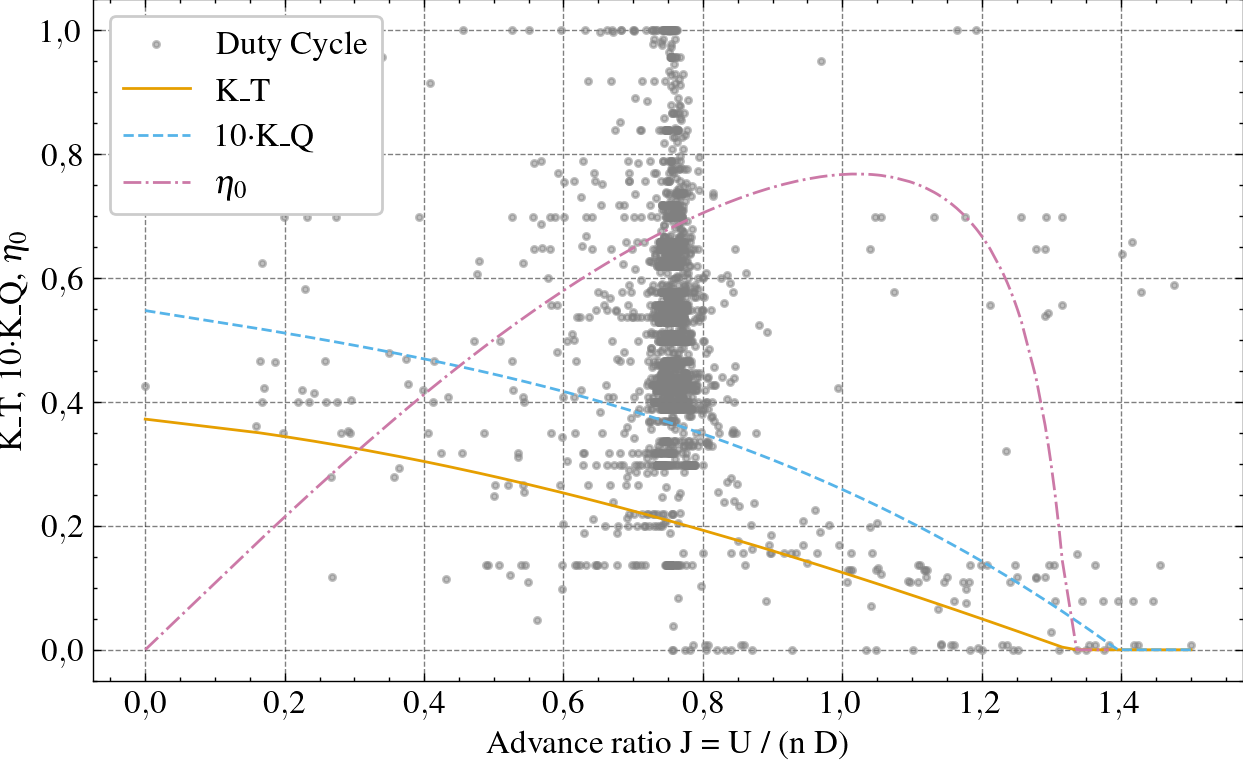

In [14]:
# 1. Classical propeller performance curve (K_T, 10K_Q, $\eta_0$ vs J)

df_prop = df_hat.copy().groupby("prop_j").mean().reset_index()

fig, ax1 = plt.subplots(figsize=figsize())
ax1.scatter(
    df_prop["prop_j"],
    df_prop["pilot_d"],
    label="Duty Cycle",
    s=5,
    alpha=0.5,
    color="grey",
)
ax1.plot(df_prop["prop_j"], df_prop["prop_k_t_ow"], label="K_T")
ax1.plot(df_prop["prop_j"], 10.0 * df_prop["prop_k_q_ow"], label="10·K_Q")
ax1.plot(df_prop["prop_j"], df_prop["prop_eta"], label=r"$\eta_0$")
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r"K_T, 10·K_Q, $\eta_0$")
ax1.grid(True)
ax1.legend(loc="best")
plt.show()

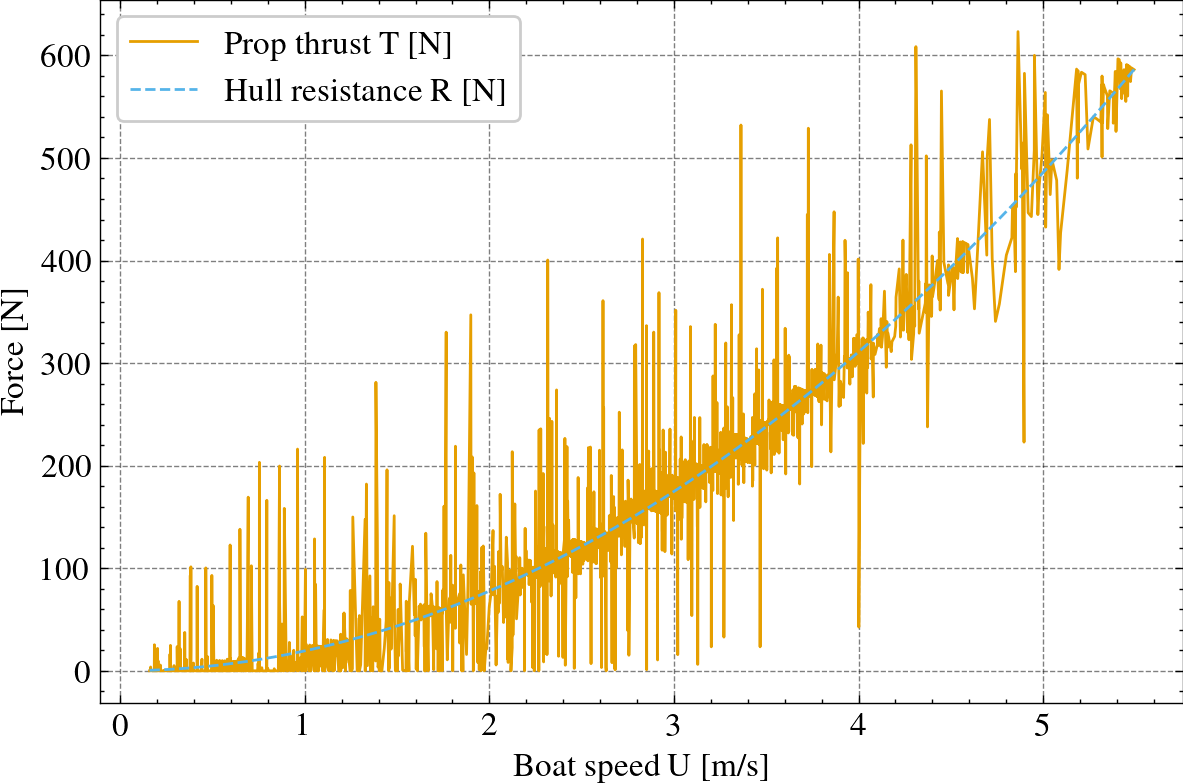

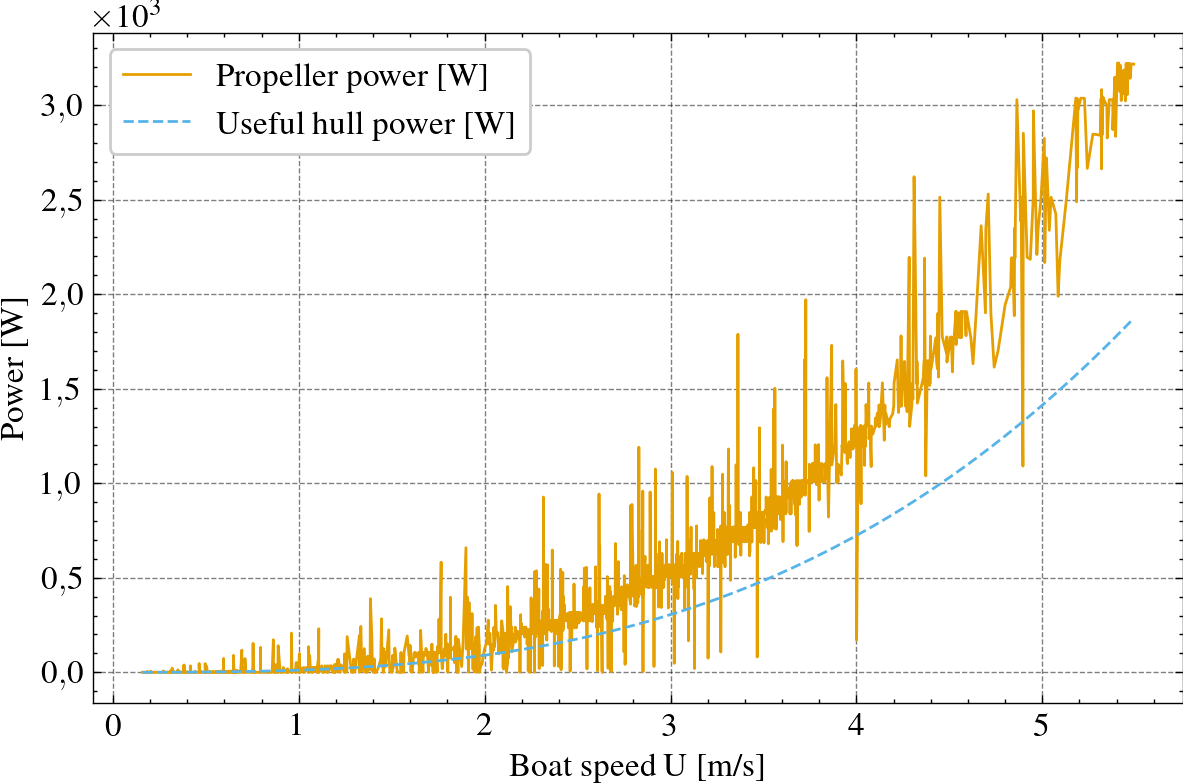

In [15]:
# 2. Boat performance curve (thrust vs resistance vs speed)

mask = df_hat["hull_u"] > 0.0
df_boat = df_hat[mask].copy().sort_values("hull_u")

plt.figure(figsize=(6, 4))
plt.plot(df_boat["hull_u"], df_boat["prop_t"], label="Prop thrust T [N]")
plt.plot(df_boat["hull_u"], df_boat["hull_r"], label="Hull resistance R [N]")
plt.xlabel("Boat speed U [m/s]")
plt.ylabel("Force [N]")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df_boat["hull_u"], df_boat["prop_p_out"], label="Propeller power [W]")
plt.plot(df_boat["hull_u"], df_boat["hull_p_out"], label="Useful hull power [W]")
plt.xlabel("Boat speed U [m/s]")
plt.ylabel("Power [W]")
plt.grid(True)
plt.legend()
plt.show()

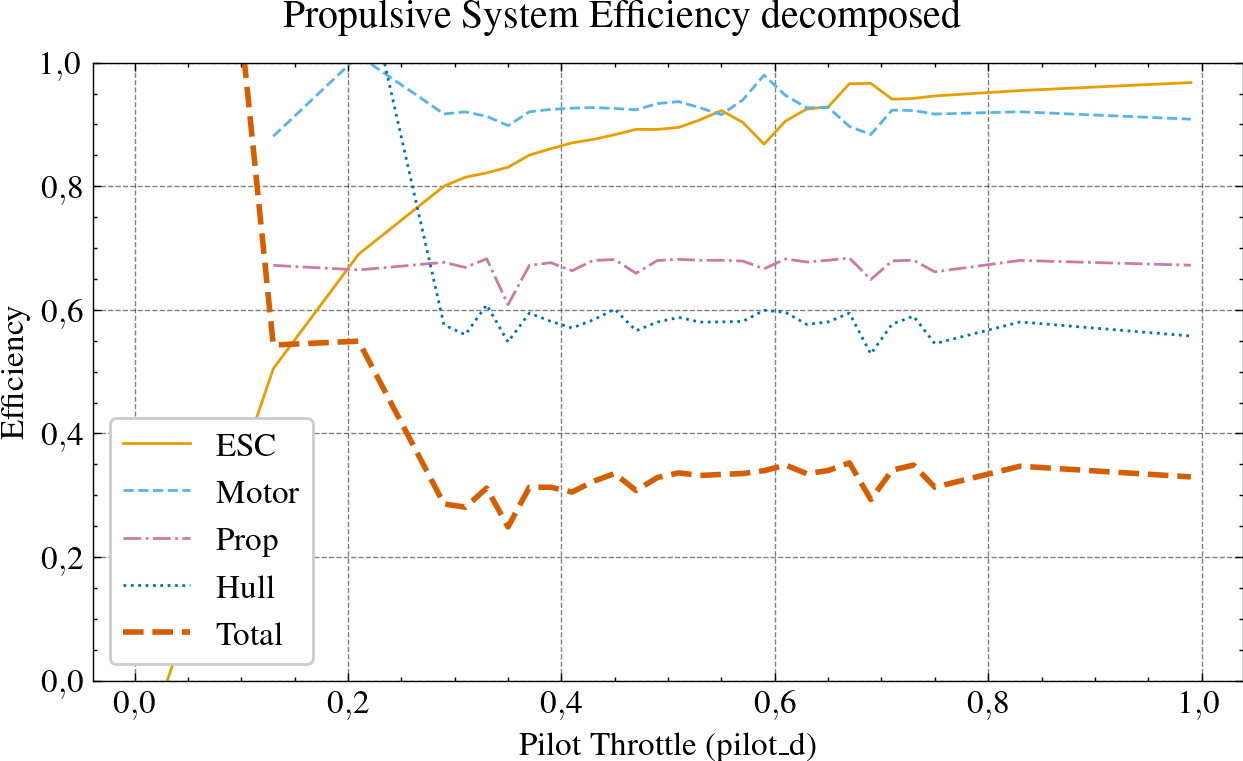

In [16]:
def safe_eta(p_out, p_in, eps=1e-6):
    p_out = np.asarray(p_out, float)
    p_in = np.asarray(p_in, float)
    out = np.full_like(p_in, np.nan, dtype=float)
    m = p_in > eps
    out[m] = p_out[m] / p_in[m]
    return out


nbins = 50
df_pred["pilot_idx"] = np.clip((df_pred["pilot_d"] * nbins).astype(int), 0, nbins - 1)
df_pred["pilot_mid"] = (df_pred["pilot_idx"] + 0.5) / nbins

g = df_pred.groupby("pilot_idx", as_index=False)

df_eta = g.agg(
    pilot_d=("pilot_mid", "mean"),
    n=("pilot_d", "size"),
    esc_p_in=("esc_p_in", "mean"),
    esc_p_out=("esc_p_out", "mean"),
    motor_p_in=("motor_p_in", "mean"),
    motor_p_out=("motor_p_out", "mean"),
    prop_p_in=("prop_p_in", "mean"),
    prop_p_out=("prop_p_out", "mean"),
    hull_p_in=("hull_p_in", "mean"),
    hull_p_out=("hull_p_out", "mean"),
).reset_index(drop=True)

# drop bins with too few samples
df_eta = df_eta[df_eta["n"] >= 20].sort_values("pilot_d")

df_eta["esc_eta"] = safe_eta(
    df_eta["esc_p_out"].to_numpy(), df_eta["esc_p_in"].to_numpy()
)
df_eta["motor_eta"] = safe_eta(
    df_eta["motor_p_out"].to_numpy(), df_eta["motor_p_in"].to_numpy()
)
df_eta["prop_eta"] = safe_eta(
    df_eta["prop_p_out"].to_numpy(), df_eta["prop_p_in"].to_numpy()
)
df_eta["hull_eta"] = safe_eta(
    df_eta["hull_p_out"].to_numpy(), df_eta["hull_p_in"].to_numpy()
)

df_eta["propulsive_eta"] = safe_eta(
    df_eta["hull_p_out"].to_numpy(), df_eta["esc_p_in"].to_numpy()
)
df_eta["propulsive_electrical_eta"] = safe_eta(
    df_eta["motor_p_out"].to_numpy(), df_eta["esc_p_in"].to_numpy()
)
df_eta["propulsive_mechanical_eta"] = safe_eta(
    df_eta["hull_p_out"].to_numpy(), df_eta["prop_p_in"].to_numpy()
)

plt.plot(df_eta["pilot_d"], df_eta["esc_eta"], label="ESC")
plt.plot(df_eta["pilot_d"], df_eta["motor_eta"], label="Motor")
plt.plot(df_eta["pilot_d"], df_eta["prop_eta"], label="Prop")
plt.plot(df_eta["pilot_d"], df_eta["hull_eta"], label="Hull")
plt.plot(df_eta["pilot_d"], df_eta["propulsive_eta"], label="Total", lw=2)

plt.xlabel("Pilot Throttle (pilot_d)")
plt.ylabel("Efficiency")
plt.suptitle("Propulsive System Efficiency decomposed")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [17]:
from utils.plot import plot_efficiency_map_scattered
from utils.control import get_steady_state_map

In [18]:
SolarBoatInternalSignalModel.build({}).input_labels

['pv_g', 'pilot_d', 'batt_v', 'mppts_i_out', 'motor_w', 'esc_i_in']

In [19]:
def model_function(T, U, X0, **params) -> pd.DataFrame:
    resp = ct.input_output_response(
        SolarBoat.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method="Radau",
    ).to_pandas()

    resp['t'] = T
    return estimate_solar_boat_signals(resp, params)

Y_ss = get_steady_state_map(
    model_class=SolarBoat,
    model_function=model_function,
    model_params=solar_boat_params,
    sweep_bounds={
        "pv_g": dict(min=0, max=1000),
        "pilot_d": dict(min=0, max=1),
    },
    sweep_steps=100,
    dt=1,
    ss_len=100,
    ss_tail_len=2,
)

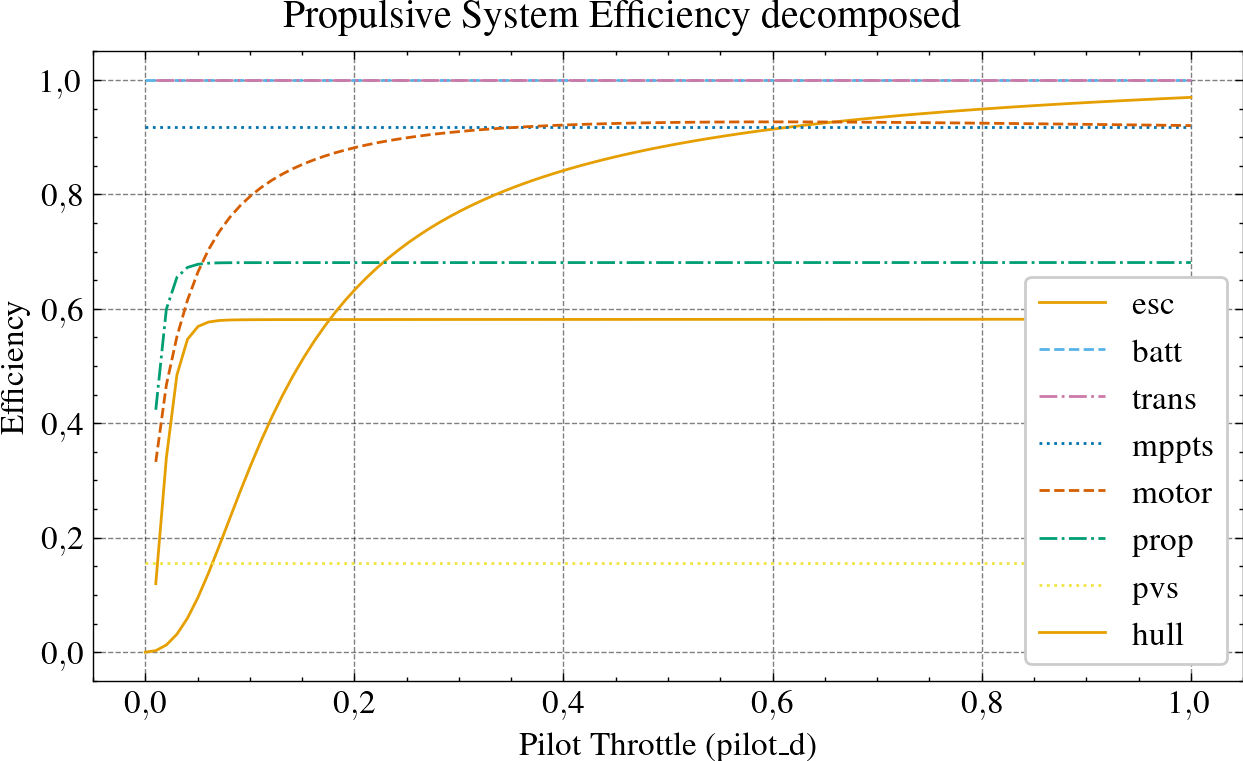

In [20]:
eta_cols = set([c for c in Y_ss.columns if c.endswith("_eta")])

Y_ss2 = Y_ss.copy().groupby("pilot_d").mean().reset_index()
for eta_col in eta_cols:
    plt.plot(Y_ss2["pilot_d"], Y_ss2[eta_col], label=eta_col[:-4])

plt.xlabel("Pilot Throttle (pilot_d)")
plt.ylabel("Efficiency")
plt.suptitle("Propulsive System Efficiency decomposed")
plt.legend()
plt.show()

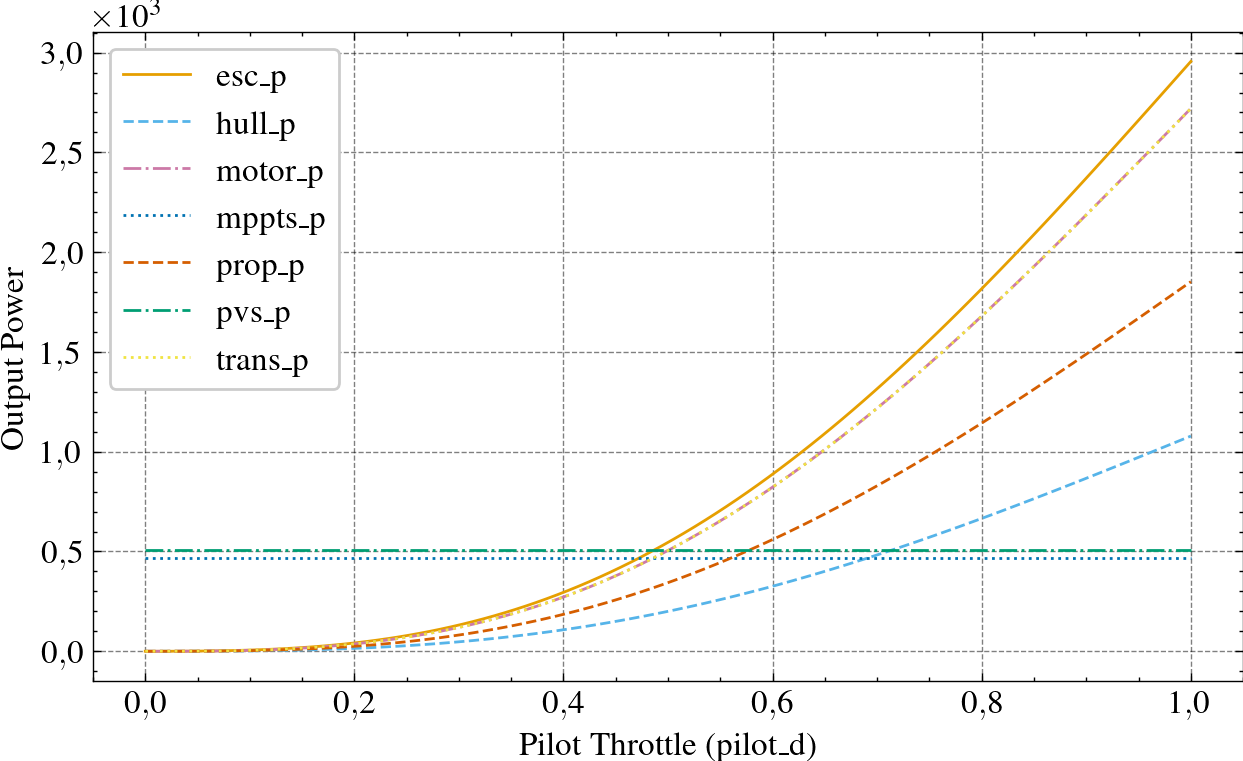

In [21]:
p_out_cols = set([c for c in Y_ss.columns if c.endswith("_p_out")])

Y_ss2 = Y_ss.copy().groupby("pilot_d").mean().reset_index()
for p_out_col in sorted(p_out_cols):
    plt.plot(Y_ss2["pilot_d"], Y_ss2[p_out_col], label=p_out_col[:-4])

plt.xlabel("Pilot Throttle (pilot_d)")
plt.ylabel("Output Power")
plt.legend()
plt.show()

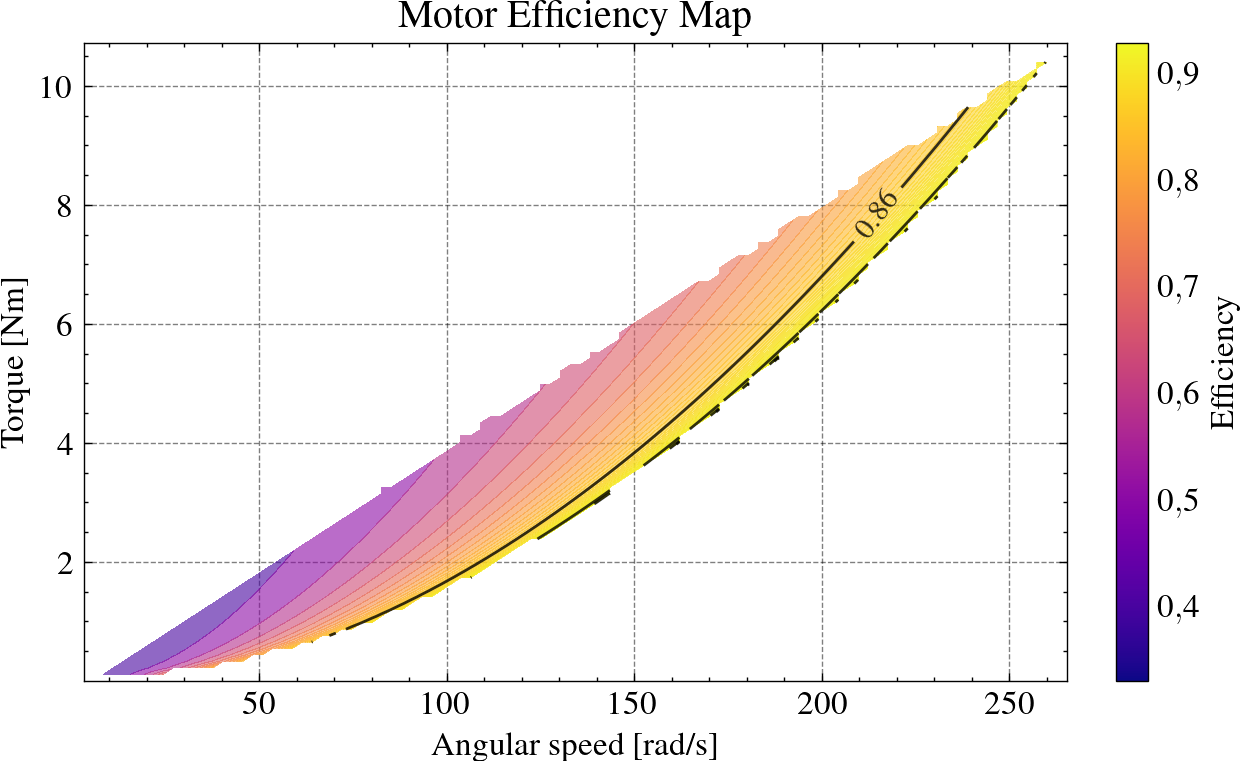

In [22]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x="motor_w",
    y="motor_q_load",
    z="motor_eta",
    nx=100,
    ny=100,
    mask_col="motor_p_out",
    mask_min=0,
    level_pmin=0,
    level_pmax=100,
    level_n=100,
    contour_lines=True,
    line_pmin=0,
    line_pmax=95,
    line_n=7,
    line_colors="k",
    label_lines=1,
    title="Motor Efficiency Map",
    xlabel="Angular speed [rad/s]",
    ylabel="Torque [Nm]",
    cbar_label="Efficiency",
    cmap="plasma",
    fill_alpha=0.6,
)
plt.show()

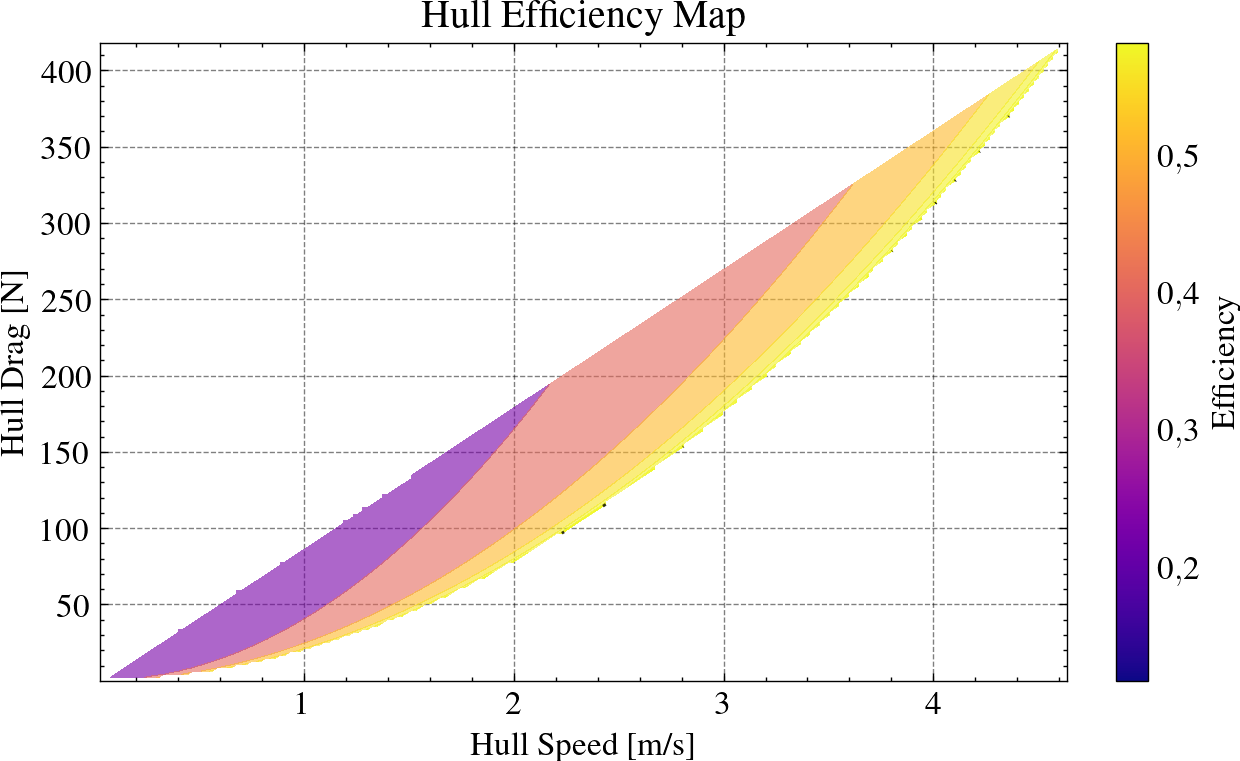

In [23]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x="hull_u",
    y="hull_r",
    z="hull_eta",
    nx=200,
    ny=200,
    mask_col="motor_p_out",
    mask_min=0,
    level_pmin=0,
    level_pmax=100,
    level_n=100,
    contour_lines=True,
    line_pmin=0,
    line_pmax=100,
    line_n=7,
    line_colors="k",
    label_lines=1,
    title="Hull Efficiency Map",
    xlabel="Hull Speed [m/s]",
    ylabel="Hull Drag [N]",
    cbar_label="Efficiency",
    cmap="plasma",
    fill_alpha=0.6,
)
plt.show()

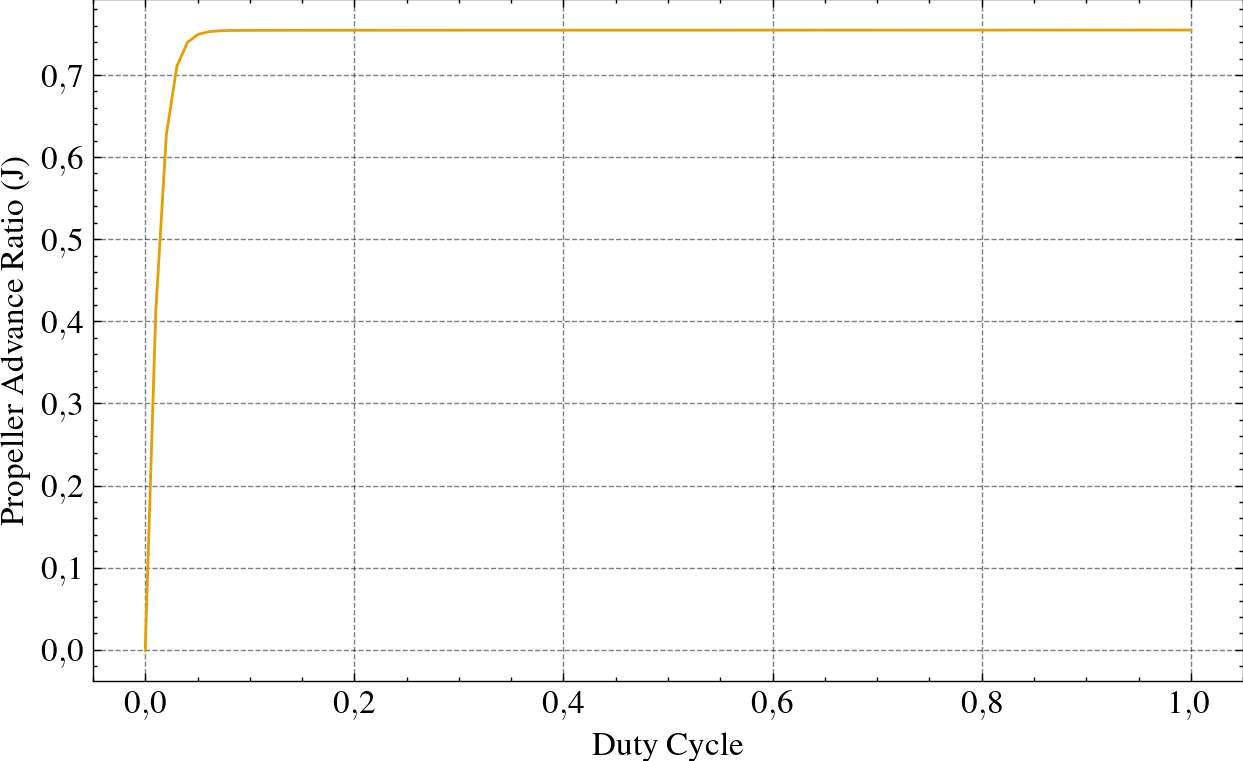

In [24]:
plt.plot(Y_ss2["esc_d"], Y_ss2["prop_j"])
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Advance Ratio (J)")
plt.show()

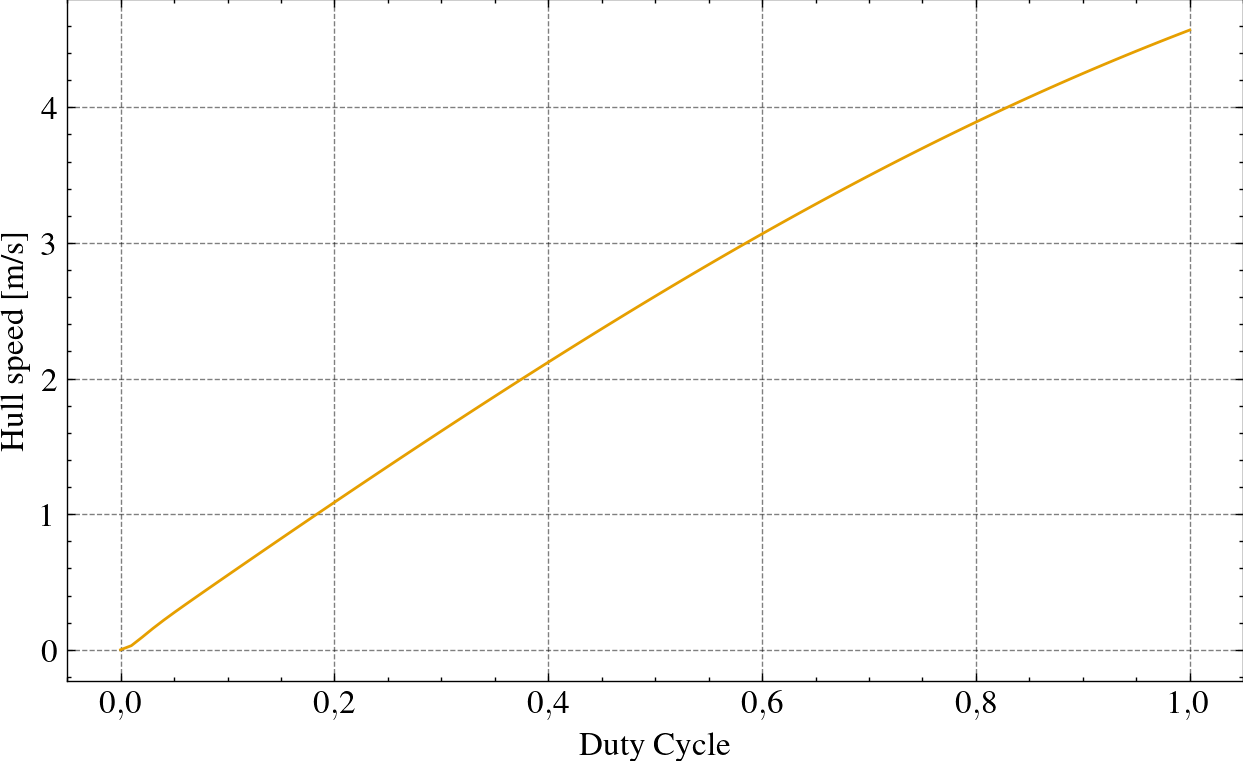

In [25]:
plt.plot(Y_ss2["esc_d"], Y_ss2["hull_u"])
plt.xlabel("Duty Cycle")
plt.ylabel("Hull speed [m/s]")
plt.show()

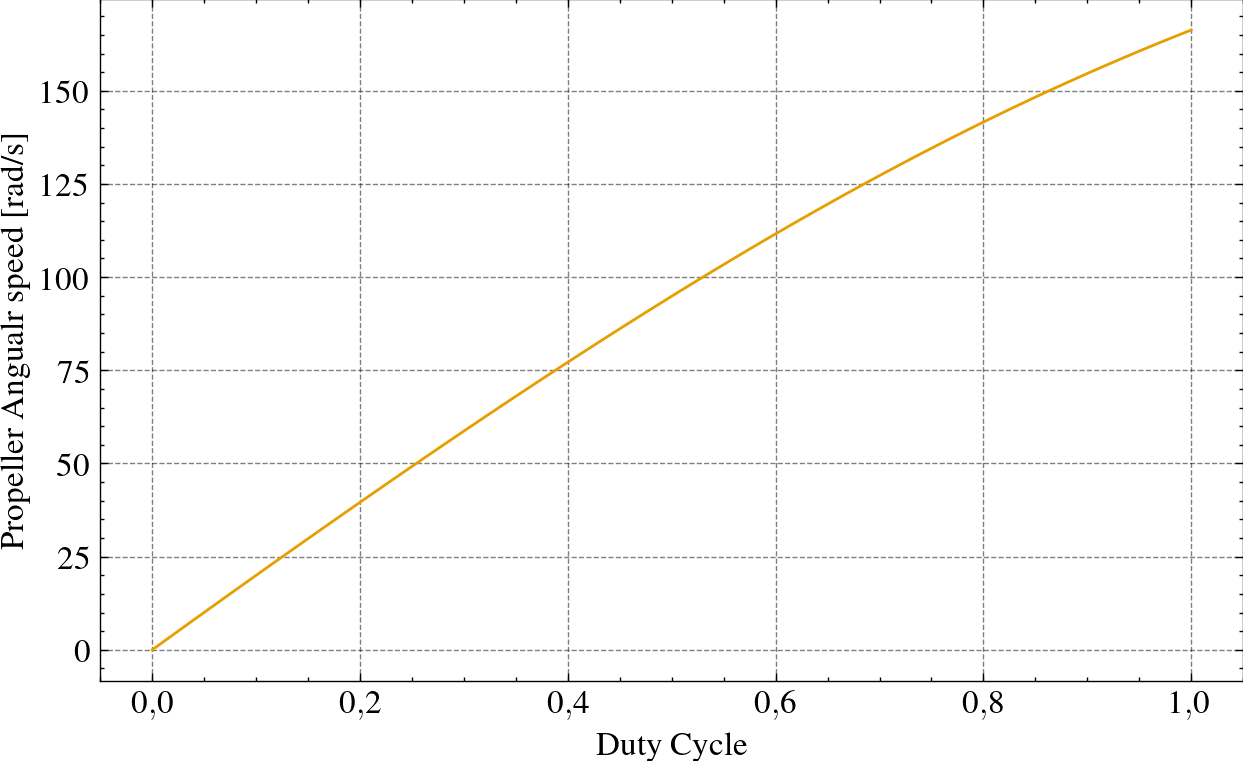

In [26]:
plt.plot(Y_ss2["esc_d"], Y_ss2["prop_w"])
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Angualr speed [rad/s]")
plt.show()

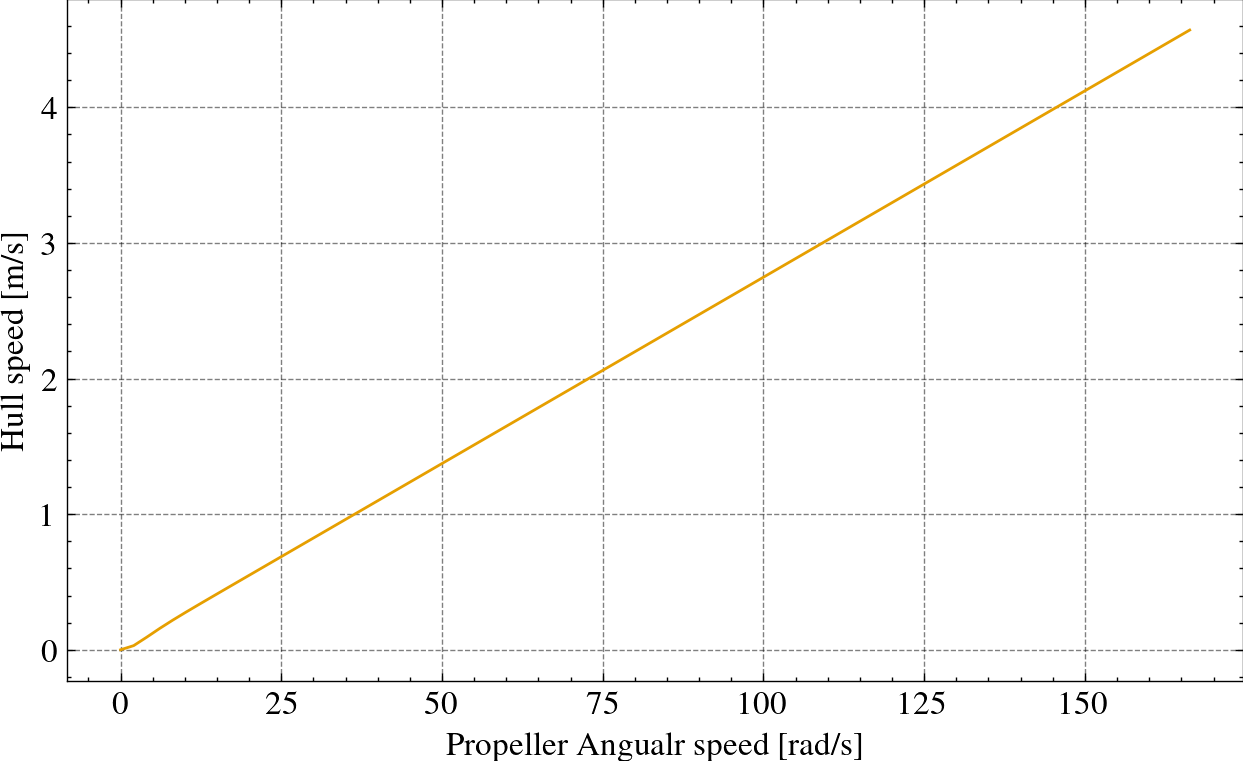

In [27]:
plt.plot(Y_ss2["prop_w"], Y_ss2["hull_u"])
plt.ylabel("Hull speed [m/s]")
plt.xlabel("Propeller Angualr speed [rad/s]")
plt.show()